In [1]:
# %load https://gist.githubusercontent.com/kidpixo/2ec078d09834b5aa7869/raw/c8812811211dc7cd62f5b530b51b0104f39263ff/ipython%20inizialization
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
import subprocess

In [43]:
class git_history:
    """ Common base class for all git history.
        
        Inizialization:
        
        foo = git_history(PATH)
        
        At the inizialitation the attribute self.path 
        that point to the git respository in PATH.
        
        Methods:
        
        The method 
        
        foo.get_history()
        
        extract the git log, and define:
        
        - foo.all_commits = the whole git log
        - foo.commits     = the commits SHA-1
        - foo.all_files   = all the unique file ever existed
        
        
        Status
        
        From the official git-log Documentation, http://git-scm.com/docs/git-log 
        for files status:

        - A : file **A**dded
        - D : file **D**eleted
        - M : file **M**odified
        
        Custom defined status:
        
        - S : file is **S**tatic (nothing happen)
        - N : file is **N**on existent

        See http://git-scm.com/docs/git-log :
        
        .......
        
        --diff-filter=[(A|C|D|M|R|T|U|X|B)…[*]]
    
        Select only files that are Added (A), Copied (C), Deleted (D), 
        Modified (M), Renamed (R), have their type (i.e. regular file,
        symlink, submodule, …) changed (T), are Unmerged (U), are 
        Unknown (X), or have had their pairing Broken (B). Any combination
        of the filter characters (including none) can be used. When * 
        (All-or-none) is added to the combination, all paths are selected if 
        there is any file that matches other criteria in the comparison; 
        if there is no file that matches other criteria, nothing is selected.
        .......
        
    """
    def __init__(self, repo_path):
        self.path = repo_path
      
    def get_history(self):
        # get the whole git history
        p = subprocess.check_output(
            ["git -C "+self.path+""" --no-pager log --reverse --name-status --oneline --pretty='format:C %h' | tr '\t' ' ' | sed -e '/^$/d' """]
            , shell=True, universal_newlines=True)
        self.all_commits = [i.split(' ') for i in p.split('\n')[0:-1]]

        # get all the commits SHA-1
        self.commits = [i[1] for i in self.all_commits if i[0] == 'C']

        # get all the file in the history
        self.all_files = sorted(set([i[1] for i in self.all_commits if i[0] != 'C']))

In [44]:
path = '/Users/damo_ma/Downloads/github_rep/git_history_visualizer'

gt = git_history(path)

gt.get_history()

### Visualize the data

We define a pandas DataFrame to contain all the files (Rows) and the status (Columns).

This Grid represent the status of each file at each step or commit.

The inizial stata for all the files is `N` or `Non existent`, they are updated in the sequential reding of `git_history.all_commits` object.

In [45]:
all_filenames = pd.DataFrame(pd.DataFrame(list(gt.all_files)),columns=gt.commits, index=gt.all_files)

def_states = {
    'A' : 120.,
    'M' : 180.,
    'S' : 255., # custom value, Static
    'D' : 240.,
    'N' : 128., # custom value, Non existent
}

def_states_explain = {
    'A' : 'Added',
    'D' : 'Deleted',
    'M' : 'Modified',
    'S' : 'Static',
    'N' : 'Non existent'
}

# fill NaN
all_filenames.fillna('N', inplace=True)

actual_commit = 0
# previous_commit = 0
for i in gt.all_commits:
    # set the commit number
    if i[0] == 'C':
        value = i[1]
        # starting at the second commit see which file exist in the previous commit
        if actual_commit != int(all_filenames.columns[0]):
             previous_commit = actual_commit
        actual_commit = value
        # assig 1 to file not null un the previous commit
        if previous_commit != 0:
            all_filenames[actual_commit][
                (all_filenames[previous_commit] != 'N') & (all_filenames[previous_commit] != 'D')] = 'S'
#             all_filenames[previous_commit][all_filenames[actual_commit] == 'D'] = 'D'
#             all_filenames[actual_commit][all_filenames[actual_commit] == 'D']   = 'N'
#         print previous_commit,'>',actual_commit
    else:
        state,value = i
#         print ' '*4,'-',state,value
        all_filenames.ix[value,actual_commit] = state

In [46]:
def plot_history_df(plot_df):

    h = plot_df.applymap(lambda x: def_states[x]).values.copy()
    h[h == 128] = np.nan

    fig = plt.figure(figsize=[10,12])

    ax = plt.subplot(111)
    for i in range(len(plot_df.index)):
        x = range(len(plot_df.columns))
        y = [i for kk in x]
        ax.scatter(x, y, s = 500, c=h[i,:], alpha=1, marker='o',linewidths = 3 , cmap = plt.cm.spectral,vmin = 0, vmax = 255)
        ax.plot(x, y, lw = 3, c='k', zorder=0)

    ax.set_xticks(range(h.shape[1]))
    ax.set_xticklabels(plot_df.columns,rotation=90)

    ax.set_xlabel('commits sha-1 (time arrow to the right ->)')
    ax.set_xlim([-.5,len(plot_df.columns)-0.5])
    ax.set_ylabel('file names')
    ax.set_yticks(range(h.shape[0]))
    ax.set_yticklabels(plot_df.index.tolist())
    print plot_df.index.tolist()
    ax.set_yticks = 0.1
    # set 0 to bounding box width
    [i.set_linewidth(0.0) for i in ax.spines.itervalues()]
    # see http://stackoverflow.com/a/20416681/1435167
    # erase x ticks
    for tic in ax.xaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False
    #     tic.label1On = tic.label2On = False
    # erase y ticks
    for tic in ax.yaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False
    #     tic.label1On = tic.label2On = False

    ax2 = fig.add_axes([0.25, .9, 0.5, 0.075])

    colors = np.array(def_states.values()).astype('float')
    colors[colors == 128] = np.nan

    x = range(len(colors))
    y = [1 for kk in x]
    ax2.scatter(x, y, s = 500, c=colors, alpha=1, marker='o',linewidths = 3, cmap = plt.cm.spectral,vmin = 0, vmax = 255)
    ax2.plot(x, y, lw = 3, c='k', zorder=0)

    ax2.set_xticks(x)
    ax2.set_xticklabels(def_states_explain.values())
    ax2.set_xlabel('Legend')
    ax2.set_xlim([-.5,len(x)-0.5])
    ax2.set_ylim([0.99,1.01])
    # set 0 to bounding box width
    [i.set_linewidth(0.0) for i in ax2.spines.itervalues()]
    # # see http://stackoverflow.com/a/20416681/1435167
    # erase x ticks
    for tic in ax2.xaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False
    # erase y ticks
    for tic in ax2.yaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False
        tic.label1On = tic.label2On = False

    # fig.savefig('/Users/damo_ma/Desktop/test.png')

['.creation.sh.swp', '.gitignore', '.ipynb_checkpoints/git_history_test_git-checkpoint.ipynb', 'LICENSE', 'README.md', 'a.txt', 'b.txt', 'c.txt', 'creation.sh', 'd.txt', 'e.txt', 'f.txt', 'git_history.ipynb', 'git_history.py', 'git_history_test_git.ipynb', 'git_history_test_git.py', 'visual_history.png']


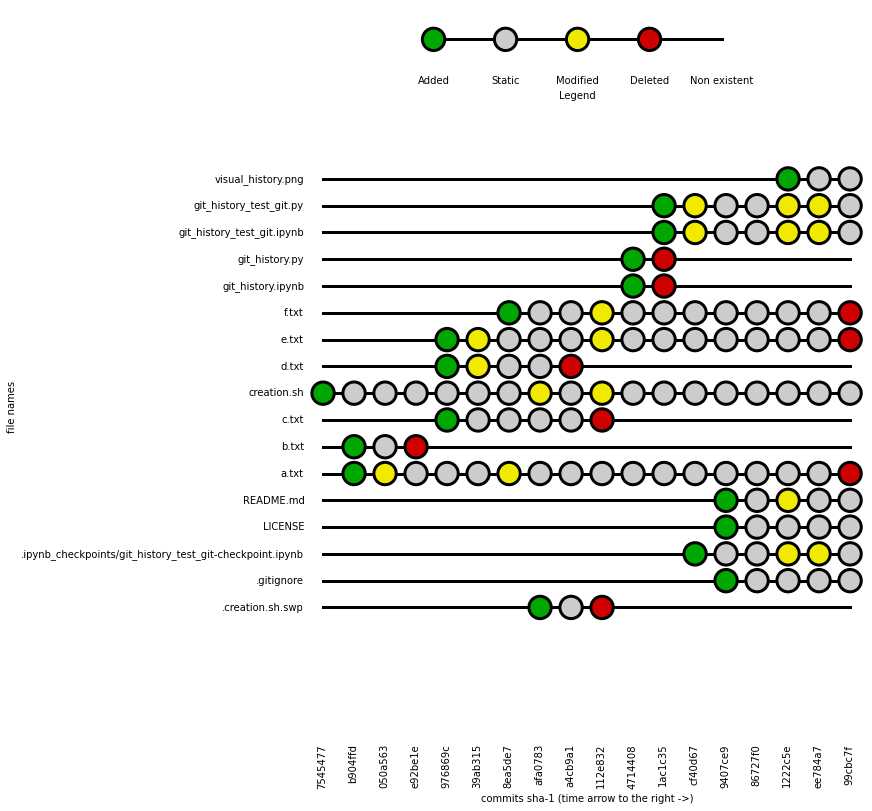

In [47]:
all_filenames
plot_history_df(all_filenames)

['.creation.sh.swp', '.gitignore', '.ipynb_checkpoints/git_history_test_git-checkpoint.ipynb', 'LICENSE', 'README.md', 'a.txt', 'b.txt', 'c.txt', 'creation.sh', 'd.txt', 'e.txt', 'f.txt', 'git_history.ipynb', 'git_history.py', 'git_history_test_git.ipynb', 'git_history_test_git.py', 'visual_history.png']


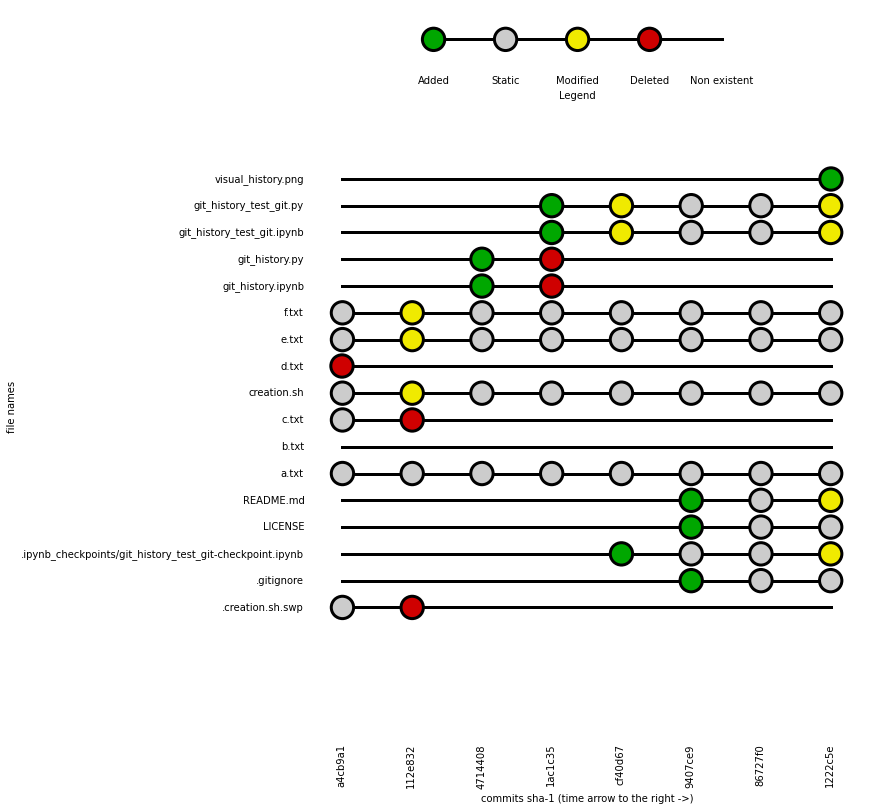

In [48]:
# filtering the history on:
# a commit range
plot_df_commit_range = all_filenames.ix[:,'a4cb9a1':'1222c5e']
plot_df_commit_range
plot_history_df(plot_df_commit_range)

['.creation.sh.swp', '.gitignore', '.ipynb_checkpoints/git_history_test_git-checkpoint.ipynb', 'LICENSE', 'README.md', 'creation.sh', 'git_history.ipynb', 'git_history.py', 'git_history_test_git.ipynb', 'git_history_test_git.py', 'visual_history.png']


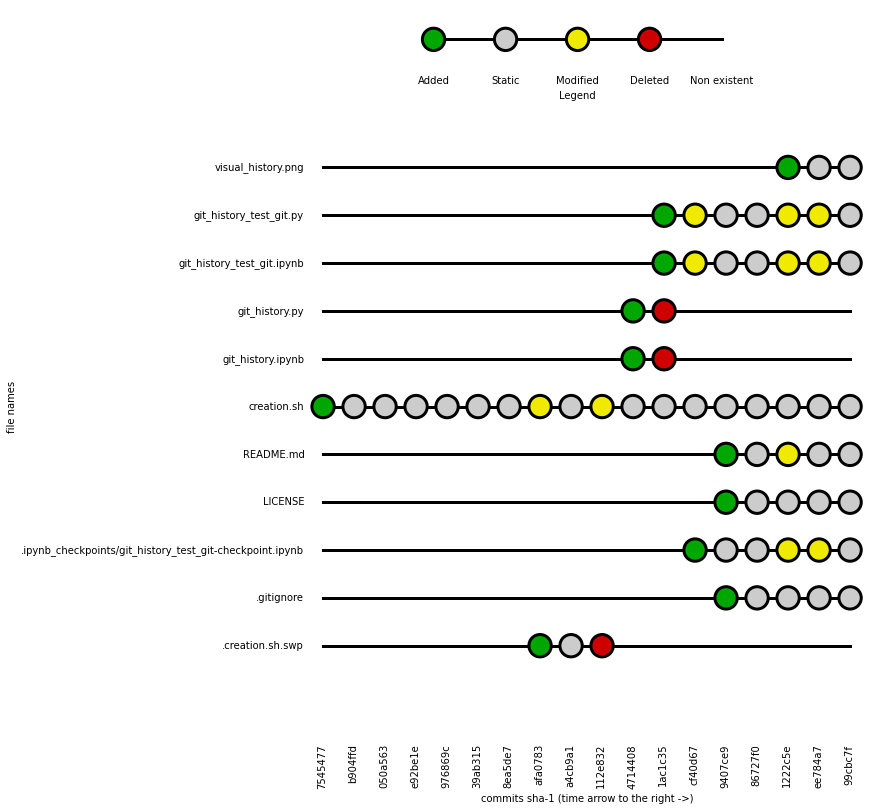

In [49]:
# filtering the history on:
# a file range: all files not ending with txt
plot_df_file_range = all_filenames[~all_filenames.index.str.contains('txt$')]
plot_df_file_range
plot_history_df(plot_df_file_range)

['.creation.sh.swp', '.gitignore', '.ipynb_checkpoints/git_history_test_git-checkpoint.ipynb', 'LICENSE', 'README.md', 'creation.sh', 'git_history.ipynb', 'git_history.py', 'git_history_test_git.ipynb', 'git_history_test_git.py', 'visual_history.png']


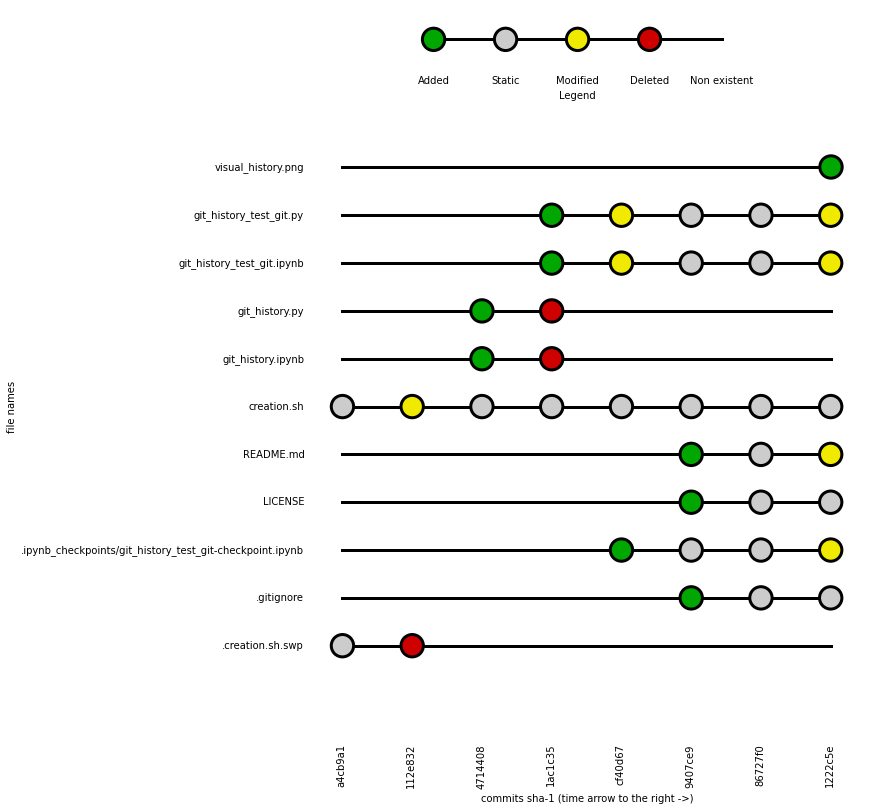

In [50]:
# filtering the history on:
# a commit range AND a file range: all files not ending with txt
plot_df_commit_file_range = all_filenames.ix[:,'a4cb9a1':'1222c5e'][~all_filenames.index.str.contains('txt$')]
plot_df_commit_file_range
plot_history_df(plot_df_commit_file_range)